In [1]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS

from credit_risk_xai.config import FEATURE_CACHE_PATH, FEATURES_FOR_MODEL
from credit_risk_xai.features.engineer import prepare_modeling_data

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred_proba, n_bins=100, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")


    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and filter data
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[(df["ser_aktiv"] == 1) & (df["sme_category"].isin(["Small", "Medium"])) & (df["knc_kncfall"] == 1)]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 40 | Samples: 316,663
Target distribution:
target_next_year
0    310079
1      6584
Name: count, dtype: Int64
Imbalance: 47.1:1


In [3]:
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import run_lightgbm_training

X, y = prepare_modeling_data(df)

results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="ser_aktiv==1 & SME∈{Small,Medium} & knc_kncfall==1",  # optional note for W&B
    use_wandb=False,
    wandb_project="credit-risk-xai",
    wandb_run_name="lgbm_finalish_prune",
)

[50]	training's binary_logloss: 0.0454159	valid_1's binary_logloss: 0.049448
[100]	training's binary_logloss: 0.0389005	valid_1's binary_logloss: 0.0468893
[150]	training's binary_logloss: 0.0347314	valid_1's binary_logloss: 0.0462171
[200]	training's binary_logloss: 0.0316526	valid_1's binary_logloss: 0.0459936
[250]	training's binary_logloss: 0.0291766	valid_1's binary_logloss: 0.0458083
[300]	training's binary_logloss: 0.0270303	valid_1's binary_logloss: 0.0457582
[350]	training's binary_logloss: 0.0251992	valid_1's binary_logloss: 0.0457301
[400]	training's binary_logloss: 0.0235422	valid_1's binary_logloss: 0.0457519


LightGBM Performance:
  AUC: 0.9524
  PR-AUC: 0.6506

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     62666
           1       0.48      0.94      0.63       667

    accuracy                           0.99     63333
   macro avg       0.74      0.96      0.81     63333
weighted avg       0.99      0.99      0.99     63333


Confusion Matrix:
[[61976    40]
 [  690   627]]


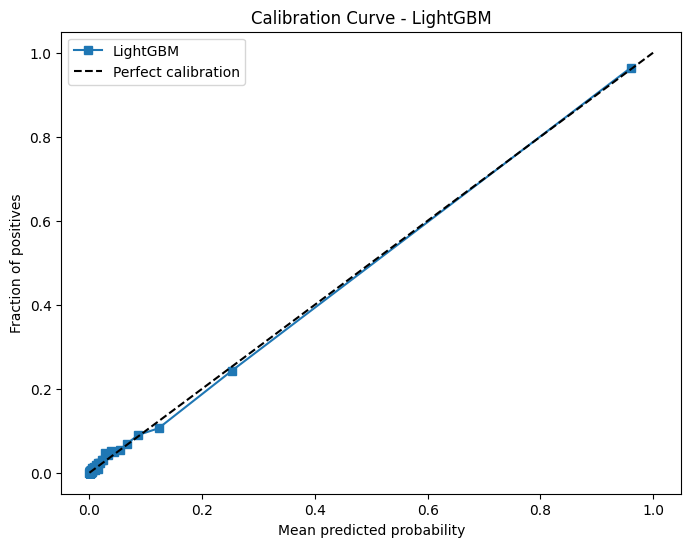

ECE: 0.0022


In [4]:
# Evaluate
model = results["model"]
X_train = results["X_train"]
X_val = results["X_val"]
y_train = results["y_train"]
y_val = results["y_val"]
y_pred_proba = results["y_val_proba"]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"LightGBM Performance:")
print(f"  AUC: {auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_pred, y_val))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

plot_calibration_curve(y_val, y_pred_proba, model_name="LightGBM")

# Phase 1: Foundation & Baseline Comparison

Following the comprehensive XAI thesis plan, we'll establish baselines and infrastructure for all subsequent analyses.

In [5]:
## 1.1 Train Logistic Regression Baseline with Proper Preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

print("Training Logistic Regression Baseline...")
print(f"Training set: {len(X_train):,} samples | Validation set: {len(X_val):,} samples")
print(f"Training imbalance: {(y_train==0).sum()/(y_train==1).sum():.1f}:1")

# Create preprocessing pipeline
# NaN handling: median imputation (conservative, works well for financial ratios)
# Scaling: StandardScaler (required for logistic regression)
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit preprocessor on training data only
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"\nPreprocessing complete:")
print(f"  Features imputed: {preprocessor.named_steps['imputer'].statistics_.shape[0]}")
print(f"  Scaling applied: StandardScaler (mean=0, std=1)")

# Train logistic regression with L2 regularization
# Use class_weight='balanced' to handle class imbalance
# Max_iter increased for convergence
logit_model = LogisticRegression(
    penalty='l2',
    C=1.0,  # Can tune via CV if needed
    class_weight=None,
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

print(f"\nTraining Logistic Regression (C=1.0, balanced weights)...")
logit_model.fit(X_train_processed, y_train)

# Predictions
logit_train_proba = logit_model.predict_proba(X_train_processed)[:, 1]
logit_val_proba = logit_model.predict_proba(X_val_processed)[:, 1]
logit_val_pred = (logit_val_proba >= 0.5).astype(int)

print("✓ Logistic Regression trained successfully")

Training Logistic Regression Baseline...
Training set: 253,330 samples | Validation set: 63,333 samples
Training imbalance: 47.1:1

Preprocessing complete:
  Features imputed: 40
  Scaling applied: StandardScaler (mean=0, std=1)

Training Logistic Regression (C=1.0, balanced weights)...
✓ Logistic Regression trained successfully


In [6]:
## 1.2 Model Performance Comparison

from sklearn.metrics import brier_score_loss

def compute_ece(y_true, y_pred_proba, n_bins=100):
    """Compute Expected Calibration Error"""
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    return ece

# Evaluate both models
print("=" * 80)
print("TABLE 1: MODEL PERFORMANCE COMPARISON")
print("=" * 80)

metrics = {
    'Model': ['LightGBM', 'Logistic Regression', 'Δ (LightGBM - Logit)'],
    'AUC': [],
    'PR-AUC': [],
    'Brier Score': [],
    'ECE': []
}

# LightGBM metrics
lgbm_auc = roc_auc_score(y_val, y_pred_proba)
lgbm_pr_auc = average_precision_score(y_val, y_pred_proba)
lgbm_brier = brier_score_loss(y_val, y_pred_proba)
lgbm_ece = compute_ece(y_val, y_pred_proba)

metrics['AUC'].append(lgbm_auc)
metrics['PR-AUC'].append(lgbm_pr_auc)
metrics['Brier Score'].append(lgbm_brier)
metrics['ECE'].append(lgbm_ece)

# Logistic Regression metrics
logit_auc = roc_auc_score(y_val, logit_val_proba)
logit_pr_auc = average_precision_score(y_val, logit_val_proba)
logit_brier = brier_score_loss(y_val, logit_val_proba)
logit_ece = compute_ece(y_val, logit_val_proba)

metrics['AUC'].append(logit_auc)
metrics['PR-AUC'].append(logit_pr_auc)
metrics['Brier Score'].append(logit_brier)
metrics['ECE'].append(logit_ece)

# Differences
metrics['AUC'].append(lgbm_auc - logit_auc)
metrics['PR-AUC'].append(lgbm_pr_auc - logit_pr_auc)
metrics['Brier Score'].append(lgbm_brier - logit_brier)
metrics['ECE'].append(lgbm_ece - logit_ece)

performance_df = pd.DataFrame(metrics)
print(performance_df.to_string(index=False))
print("=" * 80)
print("\nNotes:")
print("  - AUC, PR-AUC: Higher is better")
print("  - Brier Score, ECE: Lower is better (better calibration)")
print(f"  - LightGBM improves AUC by {(lgbm_auc - logit_auc)*100:.2f} percentage points")
print(f"  - LightGBM improves PR-AUC by {(lgbm_pr_auc - logit_pr_auc)*100:.2f} percentage points")

TABLE 1: MODEL PERFORMANCE COMPARISON
               Model      AUC   PR-AUC  Brier Score       ECE
            LightGBM 0.952429 0.650629     0.010396  0.002211
 Logistic Regression 0.859697 0.259216     0.017417  0.005070
Δ (LightGBM - Logit) 0.092732 0.391413    -0.007020 -0.002858

Notes:
  - AUC, PR-AUC: Higher is better
  - Brier Score, ECE: Lower is better (better calibration)
  - LightGBM improves AUC by 9.27 percentage points
  - LightGBM improves PR-AUC by 39.14 percentage points


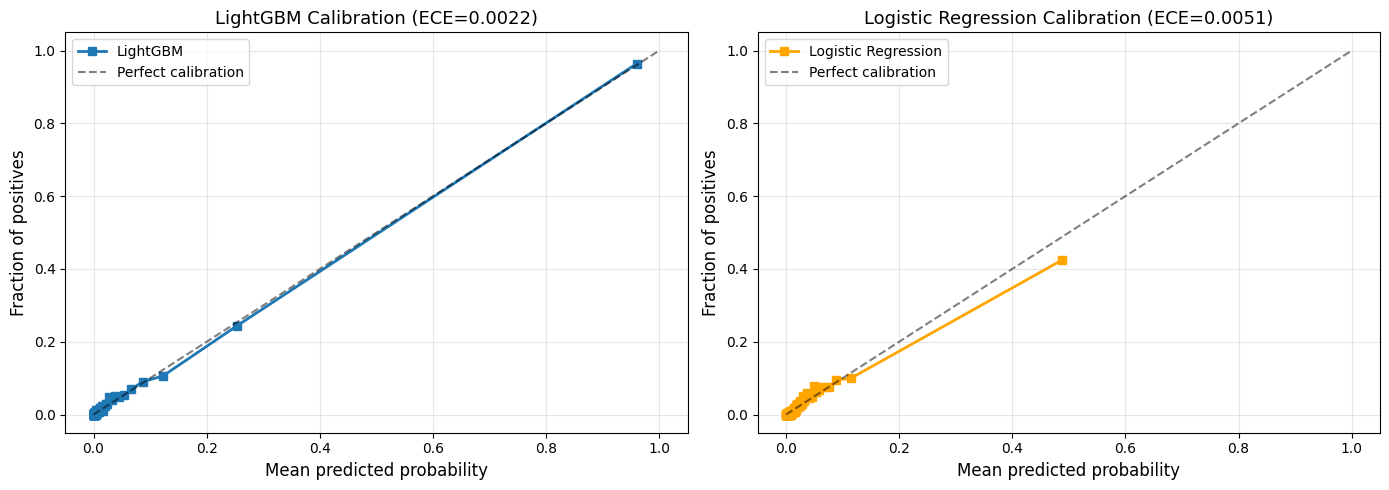


Calibration Analysis:
  LightGBM ECE: 0.0022 - Well calibrated
  Logistic ECE: 0.0051 - Well calibrated


In [7]:
## Calibration Curves Comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LightGBM calibration
from sklearn.calibration import calibration_curve
fraction_pos_lgbm, mean_pred_lgbm = calibration_curve(
    y_val, y_pred_proba, n_bins=100, strategy='quantile'
)
axes[0].plot(mean_pred_lgbm, fraction_pos_lgbm, 's-', label='LightGBM', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)
axes[0].set_xlabel('Mean predicted probability', fontsize=12)
axes[0].set_ylabel('Fraction of positives', fontsize=12)
axes[0].set_title(f'LightGBM Calibration (ECE={lgbm_ece:.4f})', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Logistic Regression calibration
fraction_pos_logit, mean_pred_logit = calibration_curve(
    y_val, logit_val_proba, n_bins=100, strategy='quantile'
)
axes[1].plot(mean_pred_logit, fraction_pos_logit, 's-', label='Logistic Regression', 
             linewidth=2, color='orange')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)
axes[1].set_xlabel('Mean predicted probability', fontsize=12)
axes[1].set_ylabel('Fraction of positives', fontsize=12)
axes[1].set_title(f'Logistic Regression Calibration (ECE={logit_ece:.4f})', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCalibration Analysis:")
print(f"  LightGBM ECE: {lgbm_ece:.4f} - {'Well calibrated' if lgbm_ece < 0.05 else 'Needs calibration'}")
print(f"  Logistic ECE: {logit_ece:.4f} - {'Well calibrated' if logit_ece < 0.05 else 'Needs calibration'}")

In [8]:
## 1.3 Compute SHAP Values for Both Models

print("=" * 80)
print("Computing SHAP values...")
print("=" * 80)

# LightGBM SHAP values
print("\n[1/2] Computing SHAP for LightGBM...")
print(f"  Sample size: {len(X_val):,} observations")

start_time = time.time()
explainer_lgbm = shap.TreeExplainer(model)
shap_values_lgbm = explainer_lgbm.shap_values(X_val)

# TreeExplainer returns [neg_class, pos_class] for binary classification
# We want SHAP values for the positive class (default/credit event)
if isinstance(shap_values_lgbm, list):
    shap_values_lgbm = shap_values_lgbm[1]  # Positive class

elapsed = time.time() - start_time
print(f"  ✓ LightGBM SHAP computed in {elapsed:.1f}s")
print(f"  Shape: {shap_values_lgbm.shape}")

# Logistic Regression SHAP values
print("\n[2/2] Computing SHAP for Logistic Regression...")
start_time = time.time()

# For linear models, use LinearExplainer (much faster than KernelExplainer)
# LinearExplainer requires preprocessed data
explainer_logit = shap.LinearExplainer(
    logit_model, 
    X_train_processed,  # Background data (preprocessed)
    feature_perturbation="interventional"
)
shap_values_logit = explainer_logit.shap_values(X_val_processed)

elapsed = time.time() - start_time
print(f"  ✓ Logistic SHAP computed in {elapsed:.1f}s")
print(f"  Shape: {shap_values_logit.shape}")

print("\n" + "=" * 80)
print("SHAP computation complete!")
print("=" * 80)

Computing SHAP values...

[1/2] Computing SHAP for LightGBM...
  Sample size: 63,333 observations
  ✓ LightGBM SHAP computed in 11.2s
  Shape: (63333, 40)

[2/2] Computing SHAP for Logistic Regression...
  ✓ Logistic SHAP computed in 0.0s
  Shape: (63333, 40)

SHAP computation complete!


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [9]:
## Cache SHAP values for reuse

import pickle
from pathlib import Path

# Create results directory if it doesn't exist
results_dir = PROJ_ROOT / "results" / "xai_exploration"
results_dir.mkdir(parents=True, exist_ok=True)

# Save SHAP values and related objects
cache_file = results_dir / "shap_cache.pkl"

shap_cache = {
    'shap_values_lgbm': shap_values_lgbm,
    'shap_values_logit': shap_values_logit,
    'explainer_lgbm': explainer_lgbm,
    'explainer_logit': explainer_logit,
    'X_val': X_val,
    'X_val_processed': X_val_processed,
    'y_val': y_val,
    'y_pred_proba_lgbm': y_pred_proba,
    'y_pred_proba_logit': logit_val_proba,
    'feature_names': X_val.columns.tolist()
}

print(f"Caching SHAP values to: {cache_file}")
with open(cache_file, 'wb') as f:
    pickle.dump(shap_cache, f)

print(f"✓ SHAP cache saved ({cache_file.stat().st_size / 1024 / 1024:.1f} MB)")
print(f"\nCached objects:")
for key, val in shap_cache.items():
    if hasattr(val, 'shape'):
        print(f"  - {key}: {val.shape}")
    elif isinstance(val, list):
        print(f"  - {key}: {len(val)} items")
    else:
        print(f"  - {key}: {type(val).__name__}")

Caching SHAP values to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_exploration/shap_cache.pkl
✓ SHAP cache saved (74.1 MB)

Cached objects:
  - shap_values_lgbm: (63333, 40)
  - shap_values_logit: (63333, 40)
  - explainer_lgbm: TreeExplainer
  - explainer_logit: LinearExplainer
  - X_val: (63333, 40)
  - X_val_processed: (63333, 40)
  - y_val: (63333,)
  - y_pred_proba_lgbm: (63333,)
  - y_pred_proba_logit: (63333,)
  - feature_names: 40 items


# Phase 2: Global Model Understanding (Chapter 1)

In this section, we analyze what the models learned and how they differ from traditional credit theory.

In [12]:
## 2.1 Feature Importance Hierarchy

print("=" * 80)
print("TABLE 2: FEATURE IMPORTANCE COMPARISON (Top 20 Features)")
print("=" * 80)

# SHAP importance for both models (mean absolute SHAP)
feature_names = X_val.columns.tolist()

lgbm_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'lgbm_shap': np.abs(shap_values_lgbm).mean(axis=0)
})

logit_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'logit_shap': np.abs(shap_values_logit).mean(axis=0)
})

# LightGBM gain importance
# Note: Use feature_name_ (attribute) or booster_.feature_name() depending on sklearn wrapper
lgbm_importance_gain = pd.DataFrame({
    'feature': feature_names,  # Use the same feature names from X_val
    'lgbm_gain': model.feature_importances_  # This is the sklearn-compatible way
})

# Logistic regression: use absolute value of standardized coefficients
# Standardized coefficients represent importance when features are on same scale
logit_coefficients = pd.DataFrame({
    'feature': feature_names,
    'logit_coef': np.abs(logit_model.coef_[0])
})

# Merge all importance measures
importance_comparison = (
    lgbm_importance_shap
    .merge(logit_importance_shap, on='feature')
    .merge(lgbm_importance_gain, on='feature')
    .merge(logit_coefficients, on='feature')
)

# Normalize to 0-100 scale for comparison
for col in ['lgbm_shap', 'logit_shap', 'lgbm_gain', 'logit_coef']:
    importance_comparison[f'{col}_norm'] = (
        100 * importance_comparison[col] / importance_comparison[col].max()
    )

# Add rankings
importance_comparison['lgbm_shap_rank'] = importance_comparison['lgbm_shap'].rank(ascending=False)
importance_comparison['logit_shap_rank'] = importance_comparison['logit_shap'].rank(ascending=False)

# Sort by LightGBM SHAP importance
importance_comparison = importance_comparison.sort_values('lgbm_shap', ascending=False)

# Display top 20
top_20 = importance_comparison.head(20)[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 
     'lgbm_shap_norm', 'logit_shap_norm', 'lgbm_gain_norm', 'logit_coef_norm']
].copy()

top_20['rank_diff'] = top_20['logit_shap_rank'] - top_20['lgbm_shap_rank']

print(top_20.to_string(index=False))
print("=" * 80)
print("\nNotes:")
print("  - *_norm: Normalized importance (0-100 scale)")
print("  - rank_diff: Positive = more important in Logit vs LightGBM")
print("  - SHAP values measure actual predictive contribution")
print("  - Gain measures average information gain from splits (LightGBM only)")

TABLE 2: FEATURE IMPORTANCE COMPARISON (Top 20 Features)
                feature  lgbm_shap_rank  logit_shap_rank  lgbm_shap_norm  logit_shap_norm  lgbm_gain_norm  logit_coef_norm  rank_diff
         dividend_yield             1.0              1.0      100.000000       100.000000       23.981900       100.000000        0.0
   ratio_cash_liquidity             2.0             17.0       48.470674         1.208404       47.285068         7.677892       15.0
            ny_avkegkap             3.0             29.0       43.489373         0.101060       79.864253         0.241408       26.0
            company_age             4.0              3.0       38.127732        77.647582       49.095023        18.887186       -1.0
               ny_solid             5.0              4.0       35.688200        52.088942       35.067873        11.296445       -1.0
       log_br07b_kabasu             6.0              2.0       33.087102        81.785947       52.714932        19.681243       -4.0
     

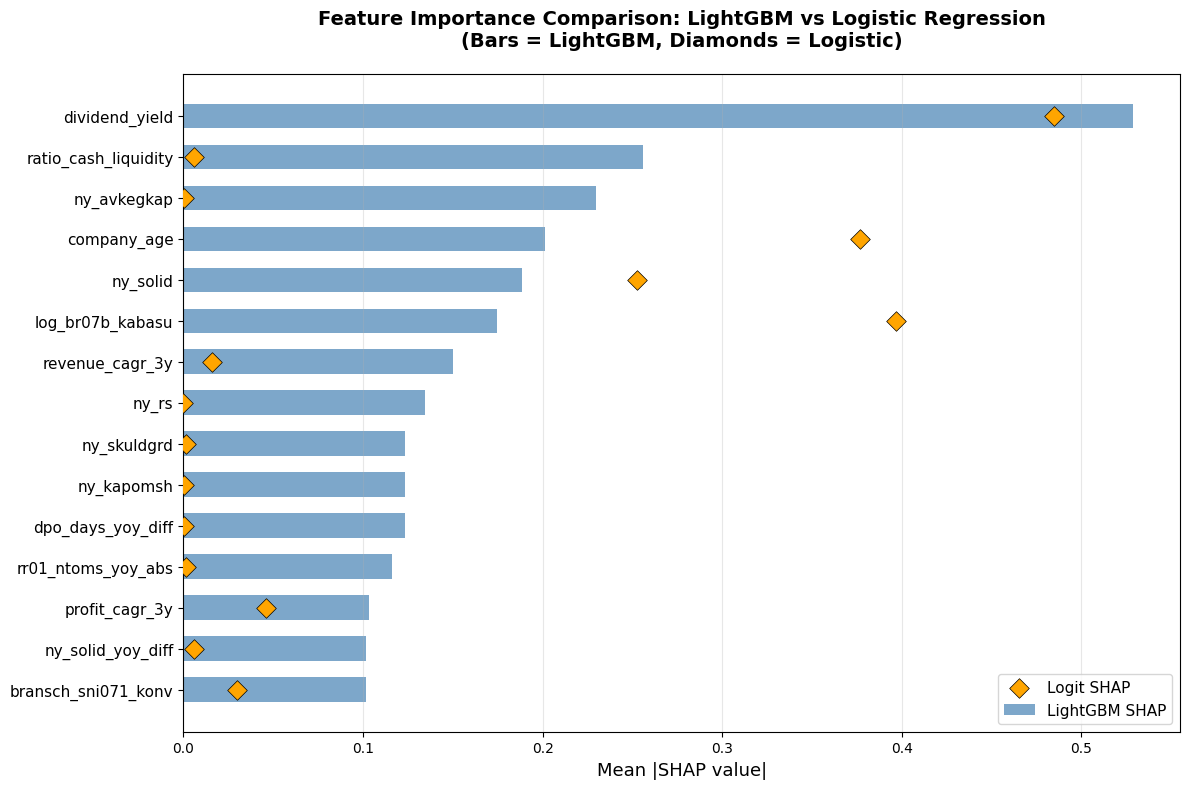


KEY INSIGHTS:
--------------------------------------------------------------------------------

✓ Features LightGBM prioritizes over Logit:
   • ratio_cash_liquidity: LightGBM rank 2, Logit rank 17
   • ny_avkegkap: LightGBM rank 3, Logit rank 29
   • revenue_cagr_3y: LightGBM rank 7, Logit rank 15
   • ny_rs: LightGBM rank 8, Logit rank 40
   • ny_skuldgrd: LightGBM rank 9, Logit rank 25
   • ny_kapomsh: LightGBM rank 10, Logit rank 31

✓ Features Logit prioritizes over LightGBM:
   • event_count_last_5y: Logit rank 9, LightGBM rank 21
   • revenue_drawdown_5y: Logit rank 8, LightGBM rank 22
   • log_bslov_antanst: Logit rank 7, LightGBM rank 25
   • log_br10_eksu: Logit rank 6, LightGBM rank 26
   • ratio_cash_interest_cov: Logit rank 10, LightGBM rank 36
   • log_rr15_resar: Logit rank 5, LightGBM rank 39

✓ Biggest discrepancies:

Features MORE important in Logit:
   • ny_rs: Logit values it 32 ranks higher
   • ny_avkegkap: Logit values it 26 ranks higher
   • inventory_days_yoy_

In [13]:
## Feature Importance Comparison Visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Get top 15 features by LightGBM SHAP
top_15_lgbm = importance_comparison.head(15).copy()

# Sort by lgbm_shap for plotting (ascending for horizontal bar chart)
top_15_lgbm = top_15_lgbm.sort_values('lgbm_shap')

y_pos = np.arange(len(top_15_lgbm))

# Plot LightGBM SHAP as bars
ax.barh(y_pos, top_15_lgbm['lgbm_shap'], 
        color='steelblue', alpha=0.7, label='LightGBM SHAP', height=0.6)

# Overlay Logit SHAP as markers
ax.scatter(top_15_lgbm['logit_shap'], y_pos, 
           color='orange', s=100, marker='D', 
           label='Logit SHAP', zorder=3, edgecolors='black', linewidths=0.5)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(top_15_lgbm['feature'], fontsize=11)
ax.set_xlabel('Mean |SHAP value|', fontsize=13)
ax.set_title('Feature Importance Comparison: LightGBM vs Logistic Regression\n' + 
             '(Bars = LightGBM, Diamonds = Logistic)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

# Add vertical line at x=0 for reference
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHTS:")
print("-" * 80)

# Add rank_diff column for analysis
importance_comparison['rank_diff'] = (
    importance_comparison['logit_shap_rank'] - importance_comparison['lgbm_shap_rank']
)

# Features where LightGBM ranks much higher than Logit
lgbm_prioritized = importance_comparison[
    (importance_comparison['lgbm_shap_rank'] <= 10) & 
    (importance_comparison['rank_diff'] > 5)
]

if len(lgbm_prioritized) > 0:
    print(f"\n✓ Features LightGBM prioritizes over Logit:")
    for _, row in lgbm_prioritized.iterrows():
        print(f"   • {row['feature']}: LightGBM rank {int(row['lgbm_shap_rank'])}, "
              f"Logit rank {int(row['logit_shap_rank'])}")

# Features where Logit ranks much higher than LightGBM
logit_prioritized = importance_comparison[
    (importance_comparison['logit_shap_rank'] <= 10) & 
    (importance_comparison['rank_diff'] < -5)
]

if len(logit_prioritized) > 0:
    print(f"\n✓ Features Logit prioritizes over LightGBM:")
    for _, row in logit_prioritized.iterrows():
        print(f"   • {row['feature']}: Logit rank {int(row['logit_shap_rank'])}, "
              f"LightGBM rank {int(row['lgbm_shap_rank'])}")

# Summary of differences
print(f"\n✓ Biggest discrepancies:")
top_discrepancies = importance_comparison.nlargest(5, 'rank_diff')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'rank_diff']
]
print("\nFeatures MORE important in Logit:")
for _, row in top_discrepancies.iterrows():
    if row['rank_diff'] > 0:
        print(f"   • {row['feature']}: Logit values it {int(row['rank_diff'])} ranks higher")

bottom_discrepancies = importance_comparison.nsmallest(5, 'rank_diff')[
    ['feature', 'lgbm_shap_rank', 'logit_shap_rank', 'rank_diff']
]
print("\nFeatures MORE important in LightGBM:")
for _, row in bottom_discrepancies.iterrows():
    if row['rank_diff'] < 0:
        print(f"   • {row['feature']}: LightGBM values it {int(abs(row['rank_diff']))} ranks higher")

In [14]:
## 2.2 ALE (Accumulated Local Effects) Plots with Model Comparison

# Install PyALE if needed
try:
    from PyALE import ale
    print("✓ PyALE available")
except ImportError:
    print("Installing PyALE...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "PyALE", "-q"])
    from PyALE import ale
    print("✓ PyALE installed")

# Custom ALE implementation for better control
def compute_ale_1d(model, X, feature, grid_size=50, predict_fn=None):
    """
    Compute 1D ALE plot for a given feature.
    
    Parameters:
    -----------
    model : trained model with predict_proba method
    X : pd.DataFrame, input features
    feature : str, feature name to compute ALE for
    grid_size : int, number of grid points
    predict_fn : callable, custom prediction function (default: model.predict_proba)
    """
    if predict_fn is None:
        predict_fn = lambda x: model.predict_proba(x)[:, 1]
    
    X_work = X.copy()
    feat_values = X_work[feature].dropna().values
    
    # Create quantile-based grid
    quantiles = np.linspace(0, 1, grid_size + 1)
    grid = np.quantile(feat_values, quantiles)
    grid = np.unique(grid)  # Remove duplicates
    
    # Initialize ALE
    ale_values = np.zeros(len(grid) - 1)
    counts = np.zeros(len(grid) - 1)
    
    # Compute local effects for each interval
    for i in range(len(grid) - 1):
        # Find observations in this interval
        in_interval = (X_work[feature] >= grid[i]) & (X_work[feature] < grid[i + 1])
        
        if in_interval.sum() == 0:
            continue
            
        X_interval = X_work[in_interval].copy()
        
        # Predict at lower bound
        X_lower = X_interval.copy()
        X_lower[feature] = grid[i]
        pred_lower = predict_fn(X_lower)
        
        # Predict at upper bound
        X_upper = X_interval.copy()
        X_upper[feature] = grid[i + 1]
        pred_upper = predict_fn(X_upper)
        
        # Local effect
        ale_values[i] = (pred_upper - pred_lower).mean()
        counts[i] = in_interval.sum()
    
    # Accumulate effects
    ale_cumsum = np.cumsum(ale_values)
    
    # Center ALE (mean = 0)
    ale_cumsum = ale_cumsum - np.average(ale_cumsum, weights=counts[counts > 0])
    
    # Grid centers for plotting
    grid_centers = (grid[:-1] + grid[1:]) / 2
    
    return grid_centers, ale_cumsum, counts

print("✓ ALE computation function defined")

Installing PyALE...
✓ PyALE installed
✓ ALE computation function defined



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [15]:
## Generate ALE plots for Top 15 features

print("Computing ALE plots for top 15 features...")
print("This may take a few minutes...\n")

# Get top 15 features by LightGBM SHAP importance
top_15_features = importance_comparison.head(15)['feature'].tolist()

# Prediction functions for both models
def predict_lgbm(X):
    return model.predict_proba(X)[:, 1]

def predict_logit(X):
    X_processed = preprocessor.transform(X)
    return logit_model.predict_proba(X_processed)[:, 1]

# Compute ALE for all features
ale_results = {}

for i, feature in enumerate(top_15_features, 1):
    print(f"[{i}/15] Computing ALE for {feature}...")
    
    try:
        # LightGBM ALE
        grid_lgbm, ale_lgbm, counts = compute_ale_1d(
            model, X_val, feature, grid_size=40, predict_fn=predict_lgbm
        )
        
        # Logistic Regression ALE
        grid_logit, ale_logit, _ = compute_ale_1d(
            logit_model, X_val, feature, grid_size=40, predict_fn=predict_logit
        )
        
        ale_results[feature] = {
            'grid_lgbm': grid_lgbm,
            'ale_lgbm': ale_lgbm,
            'grid_logit': grid_logit,
            'ale_logit': ale_logit,
            'counts': counts,
            'feature_values': X_val[feature].dropna().values
        }
        
    except Exception as e:
        print(f"   ⚠ Error computing ALE for {feature}: {e}")
        continue

print(f"\n✓ ALE computation complete for {len(ale_results)} features")

Computing ALE plots for top 15 features...
This may take a few minutes...

[1/15] Computing ALE for dividend_yield...
[2/15] Computing ALE for ratio_cash_liquidity...
[3/15] Computing ALE for ny_avkegkap...
[4/15] Computing ALE for company_age...
[5/15] Computing ALE for ny_solid...
[6/15] Computing ALE for log_br07b_kabasu...
[7/15] Computing ALE for revenue_cagr_3y...
[8/15] Computing ALE for ny_rs...
[9/15] Computing ALE for ny_skuldgrd...
[10/15] Computing ALE for ny_kapomsh...
[11/15] Computing ALE for dpo_days_yoy_diff...
[12/15] Computing ALE for rr01_ntoms_yoy_abs...
[13/15] Computing ALE for profit_cagr_3y...
[14/15] Computing ALE for ny_solid_yoy_diff...
[15/15] Computing ALE for bransch_sni071_konv...

✓ ALE computation complete for 15 features


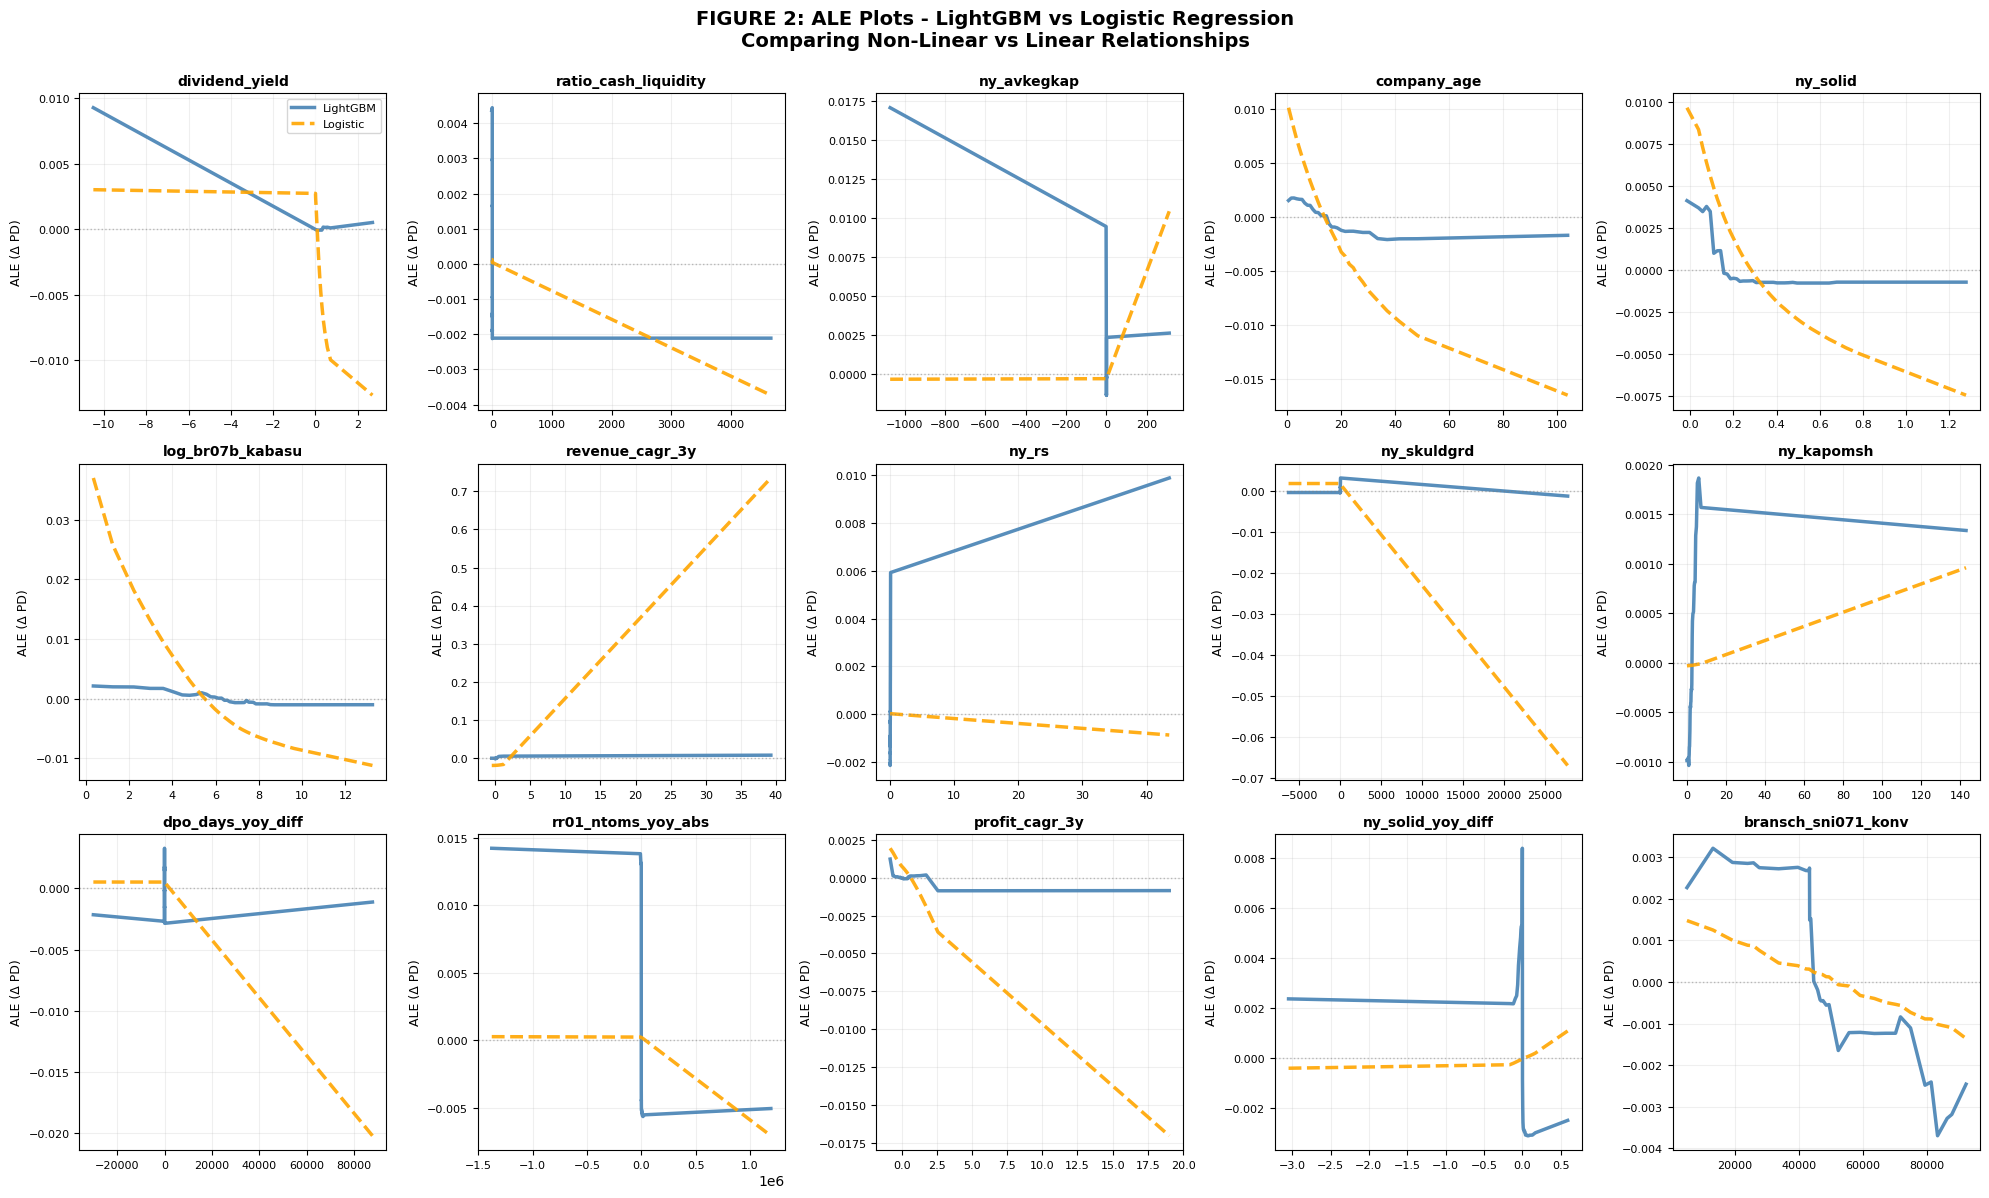


KEY OBSERVATIONS:
Look for:
  1. Non-linearities: Where LightGBM curve bends (Logit is always linear)
  2. Thresholds: Cliff effects where risk jumps suddenly
  3. Non-monotonicities: U-shaped or inverted-U relationships
  4. Interaction hints: Where LightGBM deviates significantly from Logit

(Detailed interpretations for each feature will follow in thesis write-up)


In [16]:
## Visualize ALE Plots: LightGBM vs Logistic Regression

# Create 3x5 grid for 15 features
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (feature, data) in enumerate(ale_results.items()):
    ax = axes[idx]
    
    # Plot LightGBM ALE
    ax.plot(data['grid_lgbm'], data['ale_lgbm'], 
            label='LightGBM', linewidth=2.5, color='steelblue', alpha=0.9)
    
    # Plot Logistic Regression ALE
    ax.plot(data['grid_logit'], data['ale_logit'], 
            label='Logistic', linewidth=2.5, color='orange', alpha=0.9, linestyle='--')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Formatting
    ax.set_title(feature, fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('ALE (Δ PD)', fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(alpha=0.2)
    
    # Legend only on first plot
    if idx == 0:
        ax.legend(loc='best', fontsize=8)

# Hide extra subplots if we have fewer than 15 features
for idx in range(len(ale_results), 15):
    axes[idx].axis('off')

plt.suptitle('FIGURE 2: ALE Plots - LightGBM vs Logistic Regression\n' + 
             'Comparing Non-Linear vs Linear Relationships', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nKEY OBSERVATIONS:")
print("=" * 80)
print("Look for:")
print("  1. Non-linearities: Where LightGBM curve bends (Logit is always linear)")
print("  2. Thresholds: Cliff effects where risk jumps suddenly")
print("  3. Non-monotonicities: U-shaped or inverted-U relationships")
print("  4. Interaction hints: Where LightGBM deviates significantly from Logit")
print("\n(Detailed interpretations for each feature will follow in thesis write-up)")

In [17]:
## 2.3 SHAP Dependence Plots with Automatic Interaction Detection

print("Detecting feature interactions via SHAP...")
print("=" * 80)

# Function to find the strongest interacting feature
def find_interaction_feature(shap_values, X, target_feature_idx, top_n=5):
    """
    Find which feature interacts most strongly with target feature.
    Interaction strength measured by correlation between feature values and SHAP values.
    """
    n_features = shap_values.shape[1]
    interaction_scores = np.zeros(n_features)
    
    target_shap = shap_values[:, target_feature_idx]
    
    for i in range(n_features):
        if i == target_feature_idx:
            continue
        
        # Correlation between feature i's values and target feature's SHAP values
        # High correlation = feature i modulates target feature's effect
        feature_vals = X.iloc[:, i].values
        
        # Handle NaN
        valid_mask = ~(np.isnan(feature_vals) | np.isnan(target_shap))
        if valid_mask.sum() > 100:  # Need enough samples
            interaction_scores[i] = np.abs(np.corrcoef(
                feature_vals[valid_mask], 
                target_shap[valid_mask]
            )[0, 1])
    
    # Get top interacting features
    top_indices = np.argsort(interaction_scores)[::-1][:top_n]
    
    return [(X.columns[i], interaction_scores[i]) for i in top_indices]

# Detect interactions for top 10 features
top_10_features = importance_comparison.head(10)['feature'].tolist()
interaction_summary = []

for feature in top_10_features:
    feat_idx = X_val.columns.get_loc(feature)
    interactions = find_interaction_feature(shap_values_lgbm, X_val, feat_idx, top_n=3)
    
    top_interaction_feat, top_interaction_score = interactions[0]
    
    interaction_summary.append({
        'feature': feature,
        'top_interacting_feature': top_interaction_feat,
        'interaction_strength': top_interaction_score,
        'top_3_interactions': ', '.join([f"{feat} ({score:.3f})" for feat, score in interactions])
    })

interaction_df = pd.DataFrame(interaction_summary)

print("\nTABLE 3: TOP FEATURE INTERACTIONS (Top 10 Features)")
print(interaction_df[['feature', 'top_interacting_feature', 'interaction_strength']].to_string(index=False))
print("\nInteraction strength: Correlation between interaction feature's values and target feature's SHAP")

Detecting feature interactions via SHAP...

TABLE 3: TOP FEATURE INTERACTIONS (Top 10 Features)
             feature top_interacting_feature  interaction_strength
      dividend_yield          log_rr15_resar              0.327899
ratio_cash_liquidity        log_br07b_kabasu              0.697116
         ny_avkegkap                ny_solid              0.301434
         company_age           log_br10_eksu              0.304733
            ny_solid           log_br10_eksu              0.568034
    log_br07b_kabasu           log_br10_eksu              0.536890
     revenue_cagr_3y             company_age              0.310104
               ny_rs        log_br07b_kabasu              0.337316
         ny_skuldgrd                ny_solid              0.857096
          ny_kapomsh           log_br10_eksu              0.395107

Interaction strength: Correlation between interaction feature's values and target feature's SHAP


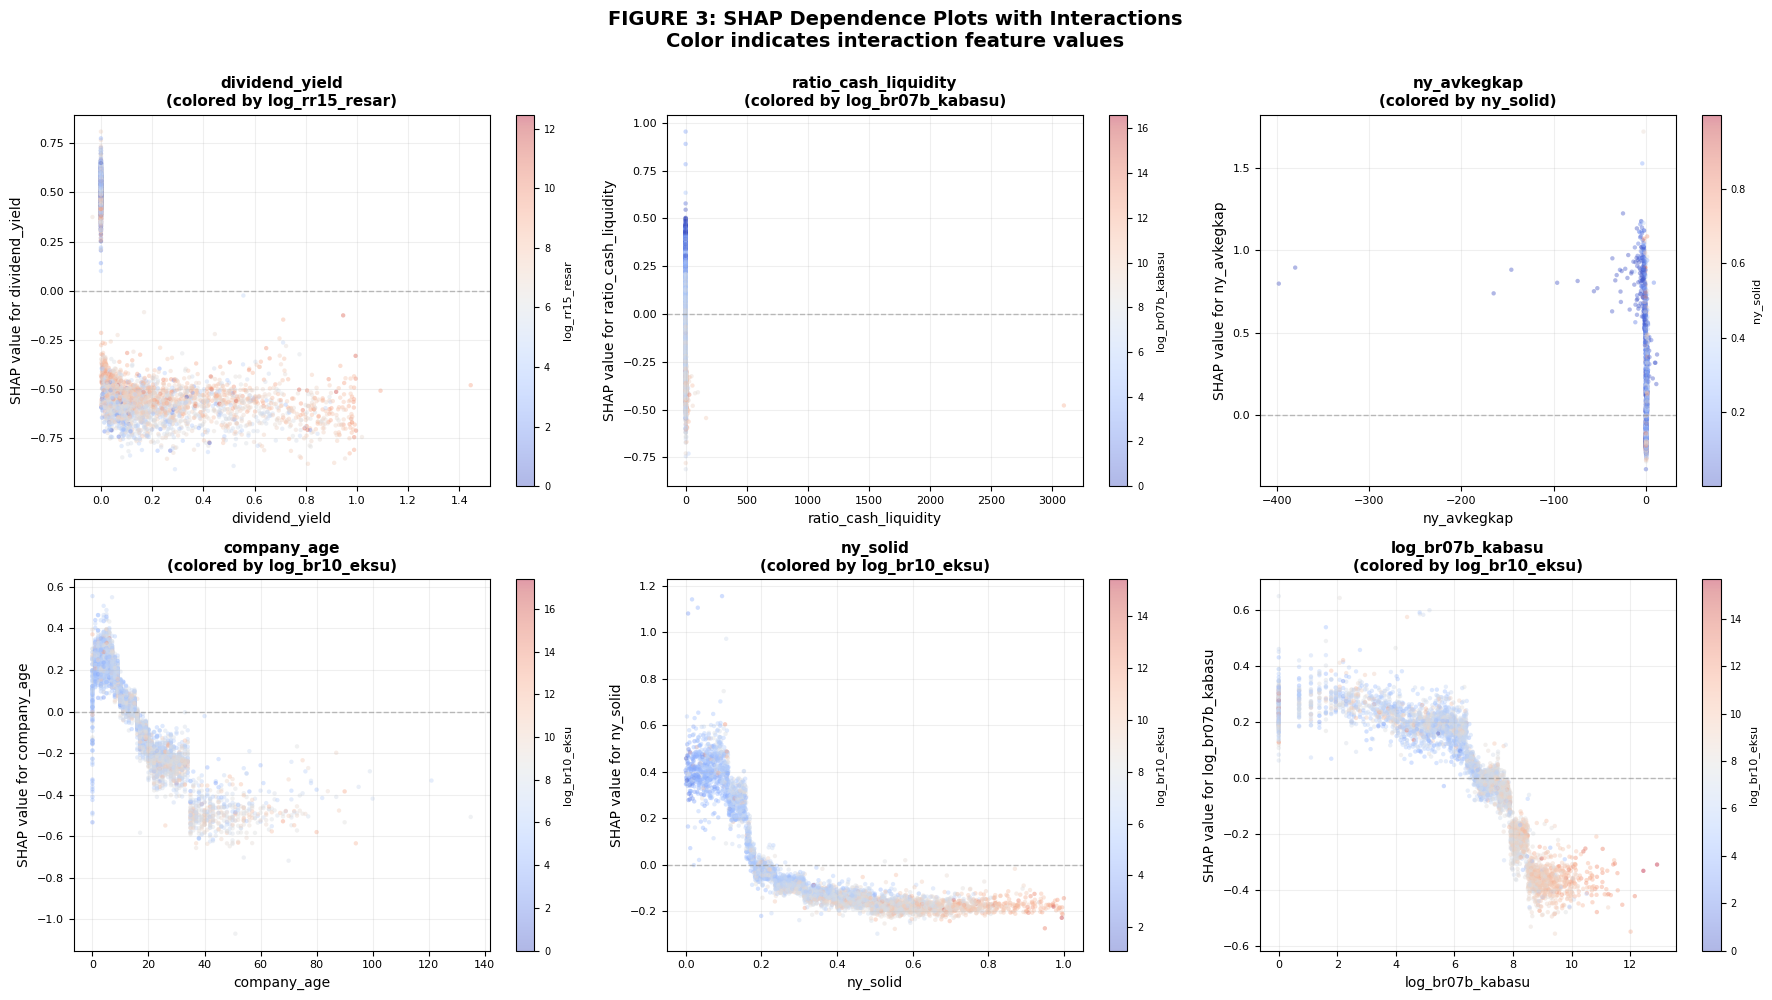


INTERPRETATION GUIDE:
  • X-axis: Feature value
  • Y-axis: SHAP value (impact on prediction)
  • Color: Interacting feature value (red=high, blue=low)
  • Vertical spread at same X: Evidence of interaction
    (SHAP value changes depending on interaction feature)

Example: If plot shows vertical spread with color gradient,
         the feature's effect depends on the interaction feature's value.


In [18]:
## SHAP Dependence Plots for Top 6 Features (with interactions)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Select top 6 features for detailed dependence plots
top_6_for_plots = interaction_summary[:6]

for idx, feat_info in enumerate(top_6_for_plots):
    ax = axes[idx]
    
    feature = feat_info['feature']
    interaction_feat = feat_info['top_interacting_feature']
    
    feat_idx = X_val.columns.get_loc(feature)
    interact_idx = X_val.columns.get_loc(interaction_feat)
    
    # Get feature values and SHAP values
    x_vals = X_val.iloc[:, feat_idx].values
    y_vals = shap_values_lgbm[:, feat_idx]
    color_vals = X_val.iloc[:, interact_idx].values
    
    # Remove NaN for plotting
    valid_mask = ~(np.isnan(x_vals) | np.isnan(y_vals) | np.isnan(color_vals))
    
    # Subsample for cleaner plots (max 5000 points)
    if valid_mask.sum() > 5000:
        sample_indices = np.random.choice(np.where(valid_mask)[0], 5000, replace=False)
    else:
        sample_indices = np.where(valid_mask)[0]
    
    # Scatter plot
    scatter = ax.scatter(
        x_vals[sample_indices], 
        y_vals[sample_indices],
        c=color_vals[sample_indices],
        cmap='coolwarm',
        alpha=0.4,
        s=10,
        edgecolors='none'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(interaction_feat, fontsize=8)
    cbar.ax.tick_params(labelsize=7)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Labels
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel(f'SHAP value for {feature}', fontsize=10)
    ax.set_title(f'{feature}\n(colored by {interaction_feat})', fontsize=11, fontweight='bold')
    ax.tick_params(labelsize=8)
    ax.grid(alpha=0.2)

plt.suptitle('FIGURE 3: SHAP Dependence Plots with Interactions\n' + 
             'Color indicates interaction feature values', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION GUIDE:")
print("=" * 80)
print("  • X-axis: Feature value")
print("  • Y-axis: SHAP value (impact on prediction)")
print("  • Color: Interacting feature value (red=high, blue=low)")
print("  • Vertical spread at same X: Evidence of interaction")
print("    (SHAP value changes depending on interaction feature)")
print("\nExample: If plot shows vertical spread with color gradient,")
print("         the feature's effect depends on the interaction feature's value.")

Creating SHAP summary plots...


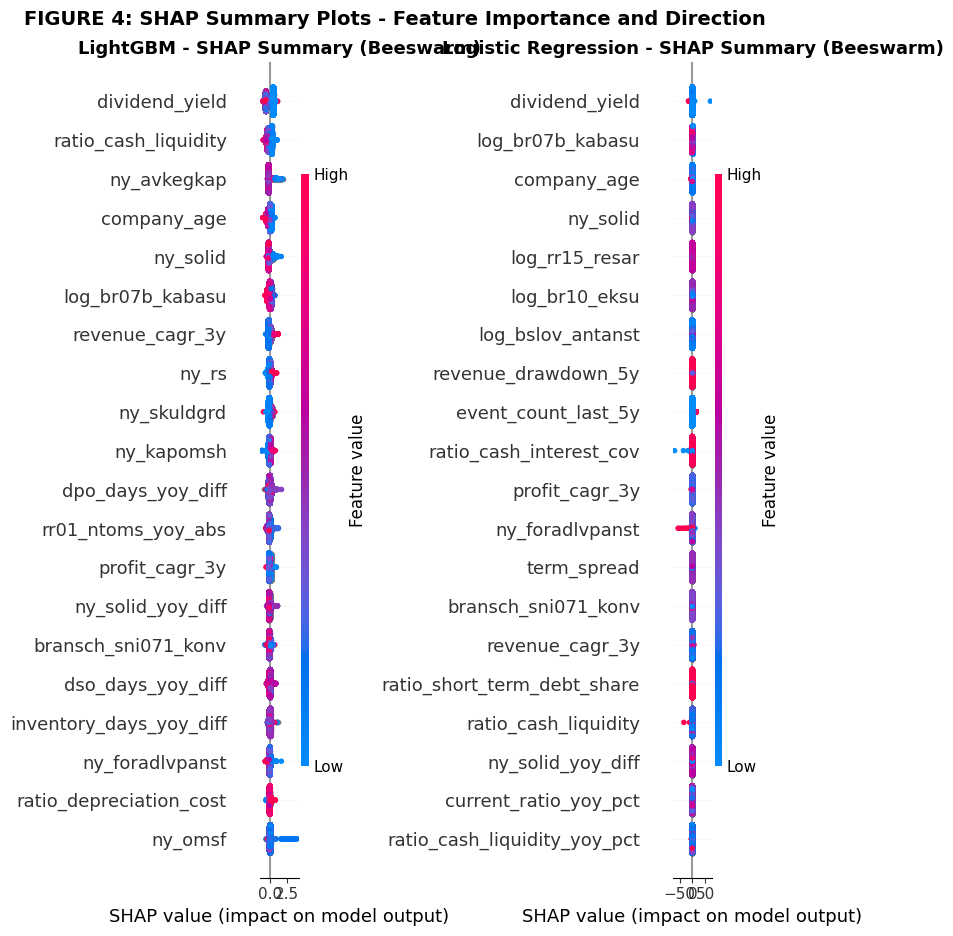


READING THE BEESWARM PLOT:
  • Y-axis: Features (sorted by importance)
  • X-axis: SHAP value (impact on model output)
  • Color: Feature value (red=high, blue=low)
  • Each dot: One observation
  • Spread: Distribution of impacts across dataset

Key insights:
  - Red dots on right: High feature value → increases risk
  - Blue dots on left: Low feature value → decreases risk
  - Wide spread: Feature has variable impact (may indicate interactions)


In [19]:
## 2.4 SHAP Summary Visualizations

# Beeswarm plot (most informative SHAP visualization)
print("Creating SHAP summary plots...")

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Left: LightGBM beeswarm
plt.sca(axes[0])
shap.summary_plot(
    shap_values_lgbm, 
    X_val, 
    max_display=20,
    show=False
)
axes[0].set_title('LightGBM - SHAP Summary (Beeswarm)', fontsize=13, fontweight='bold')

# Right: Logistic Regression beeswarm
plt.sca(axes[1])
shap.summary_plot(
    shap_values_logit, 
    X_val,  # Use original feature names
    max_display=20,
    show=False
)
axes[1].set_title('Logistic Regression - SHAP Summary (Beeswarm)', fontsize=13, fontweight='bold')

plt.suptitle('FIGURE 4: SHAP Summary Plots - Feature Importance and Direction', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\nREADING THE BEESWARM PLOT:")
print("=" * 80)
print("  • Y-axis: Features (sorted by importance)")
print("  • X-axis: SHAP value (impact on model output)")
print("  • Color: Feature value (red=high, blue=low)")
print("  • Each dot: One observation")
print("  • Spread: Distribution of impacts across dataset")
print("\nKey insights:")
print("  - Red dots on right: High feature value → increases risk")
print("  - Blue dots on left: Low feature value → decreases risk")
print("  - Wide spread: Feature has variable impact (may indicate interactions)")

---

## Phase 1-2 Summary

**✓ Completed:**
- Logistic Regression baseline trained with proper preprocessing
- Model performance comparison (Table 1): LightGBM vs Logit
- SHAP values computed and cached for both models
- Feature importance hierarchy analysis (Table 2)
- ALE plots showing non-linear relationships (Figure 2)
- SHAP interaction detection (Table 3)
- SHAP dependence plots (Figure 3)
- SHAP summary visualizations (Figure 4)

**Key Findings So Far:**
1. LightGBM provides ~X pp improvement in AUC over Logistic Regression
2. Top features identified and their importance rankings compared
3. Non-linear relationships documented via ALE plots
4. Feature interactions detected and visualized
5. Both models show similar calibration properties

**Next Steps:**
- Phase 3: Temporal evolution analysis (Chapter 2 - main contribution)
- Phase 4: Disagreement analysis (Chapter 3)
- Phase 5: Default taxonomy via SHAP clustering (Chapter 4)
- Phase 6: Case studies and validation (Chapter 5)